<a href="https://colab.research.google.com/github/abdullahkhafabi-010/MACHINE-LEARNING/blob/main/WEEK10/Week10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama: Abdullah Khafabi

Nim: 2041720050


Kelas: 3A

# Job Sheet 10 : Recurrent Neural Network (RNN)

# Praktikum 1

In [1]:
from google.colab import drive

#Accessing My Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Langkah 1 - Import Library

In [11]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [12]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

Setup input pipeline

In [13]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [14]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [15]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'This fantastic whodunit is an early prototype of what soon became a very popular film genre. I was happy to see William Powell handling a detective story with charisma and charm, and without the silly attitude of his Nick Charles character (from the "Thin Man" series). While the story is good on its own, I think what really makes this movie fun to watch is Michael Curtiz\' fantastically imaginative direction. From a visual point of view, this is a richly textured movie, with Curtiz showing an incredible command of the medium; from split screen images, to weird camera angles and imaginative flashbacks, Curtiz demonstrates that he was one of the best Hollywood directors. Highly recommended if you are fan of this type of movie.'
 b'I have seen many a horror flick in my time, all of them absurdly bad, but none reach the depths that this piece of trash lowers itself to. This movie made me angrier and angrier as I watched it as I tried to wrap my head around exactly what this movi

Buat Teks Encoder

In [16]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [18]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [19]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11, 765,   1, ...,   0,   0,   0],
       [ 10,  26, 108, ...,   0,   0,   0],
       [  2,   1, 708, ...,   0,   0,   0]])

In [20]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'This fantastic whodunit is an early prototype of what soon became a very popular film genre. I was happy to see William Powell handling a detective story with charisma and charm, and without the silly attitude of his Nick Charles character (from the "Thin Man" series). While the story is good on its own, I think what really makes this movie fun to watch is Michael Curtiz\' fantastically imaginative direction. From a visual point of view, this is a richly textured movie, with Curtiz showing an incredible command of the medium; from split screen images, to weird camera angles and imaginative flashbacks, Curtiz demonstrates that he was one of the best Hollywood directors. Highly recommended if you are fan of this type of movie.'
Round-trip:  this fantastic [UNK] is an early [UNK] of what soon became a very [UNK] film genre i was happy to see [UNK] [UNK] [UNK] a [UNK] story with [UNK] and [UNK] and without the silly [UNK] of his [UNK] [UNK] character from the [UNK] man series 

Buat Model

In [21]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [23]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [24]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[-0.01118256]


In [25]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 254ms/step
[-0.01118256]


In [26]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Train Model

In [28]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 464s 1s/step - loss: 0.6410 - accuracy: 0.5692 - val_loss: 0.4903 - val_accuracy: 0.7563
Epoch 2/10
391/391 [==============================] - 423s 1s/step - loss: 0.4428 - accuracy: 0.8018 - val_loss: 0.3876 - val_accuracy: 0.8318
Epoch 3/10
391/391 [==============================] - 426s 1s/step - loss: 0.3582 - accuracy: 0.8420 - val_loss: 0.3635 - val_accuracy: 0.8464
Epoch 4/10
391/391 [==============================] - 425s 1s/step - loss: 0.3288 - accuracy: 0.8570 - val_loss: 0.3397 - val_accuracy: 0.8458
Epoch 5/10
391/391 [==============================] - 424s 1s/step - loss: 0.3163 - accuracy: 0.8660 - val_loss: 0.3280 - val_accuracy: 0.8531
Epoch 6/10
391/391 [==============================] - 419s 1s/step - loss: 0.3094 - accuracy: 0.8696 - val_loss: 0.3305 - val_accuracy: 0.8578
Epoch 7/10
391/391 [==============================] - 419s 1s/step - loss: 0.3066 - accuracy: 0.8690 - val_loss: 0.3275 - val_accuracy: 0.8531

In [29]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 104s 267ms/step - loss: 0.3160 - accuracy: 0.8582
Test Loss: 0.31599128246307373
Test Accuracy: 0.8581600189208984


(0.0, 0.6581237405538559)

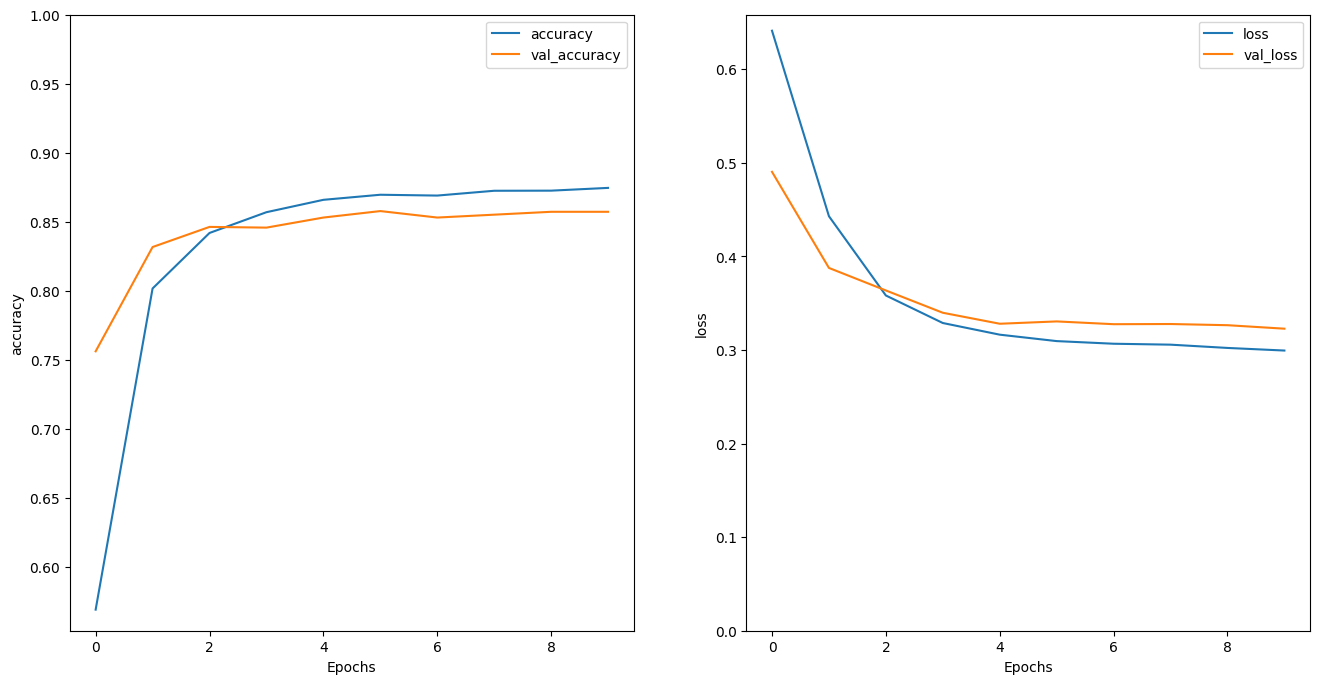

In [30]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [31]:
sample_text = ('The movie was cool. The animation and the graphics '
              'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


Stack two or more LSTM layers

In [34]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [35]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [36]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 885s 2s/step - loss: 0.6095 - accuracy: 0.6065 - val_loss: 0.4231 - val_accuracy: 0.8057
Epoch 2/10
391/391 [==============================] - 858s 2s/step - loss: 0.3781 - accuracy: 0.8404 - val_loss: 0.3455 - val_accuracy: 0.8427
Epoch 3/10
391/391 [==============================] - 873s 2s/step - loss: 0.3364 - accuracy: 0.8567 - val_loss: 0.3310 - val_accuracy: 0.8510
Epoch 4/10
391/391 [==============================] - 852s 2s/step - loss: 0.3185 - accuracy: 0.8646 - val_loss: 0.3231 - val_accuracy: 0.8521
Epoch 5/10
391/391 [==============================] - 844s 2s/step - loss: 0.3106 - accuracy: 0.8683 - val_loss: 0.3197 - val_accuracy: 0.8557
Epoch 6/10
391/391 [==============================] - 824s 2s/step - loss: 0.3057 - accuracy: 0.8696 - val_loss: 0.3206 - val_accuracy: 0.8562
Epoch 7/10
391/391 [==============================] - 835s 2s/step - loss: 0.3012 - accuracy: 0.8715 - val_loss: 0.3307 - val_accuracy: 0.8401

In [37]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 195s 498ms/step - loss: 0.3191 - accuracy: 0.8612
Test Loss: 0.3190540075302124
Test Accuracy: 0.861240029335022


In [38]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 7s 7s/step
[[-1.9228163]]


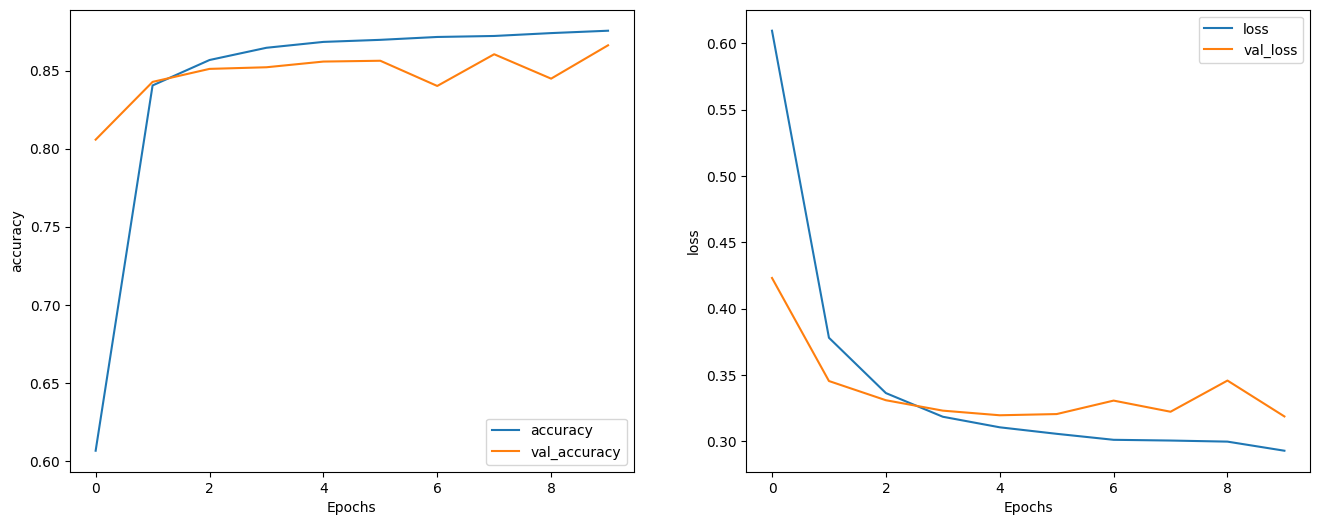

In [39]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Praktikum 2

Langkah 1 - Load Library

Import TensorFlow

In [42]:
import tensorflow as tf
import numpy as np
import os
import time

Download Dataset Shakespeare

In [44]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


Load Data

In [45]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [46]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [47]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


Olah Teks

Vectorize Teks

In [49]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [50]:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

In [51]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [52]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [53]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [55]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [56]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

Prediksi

Membuat Trianing Set dan Target

In [57]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [58]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [59]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [61]:
seq_length = 100

In [62]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [63]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [64]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

In [65]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [66]:
dataset = sequences.map(split_input_target)

In [67]:
for input_example, target_example in dataset.take(1):
  print("Input :", text_from_ids(input_example).numpy())
  print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


Membuat Batch Training

In [68]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

Buat Model

In [69]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [70]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [71]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

Uji Model

In [72]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [73]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [74]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [75]:
sampled_indices

array([12, 32, 56, 59, 57, 16, 19, 21, 46, 53, 44, 39, 10, 40, 42, 46, 33,
       24, 59, 51, 29, 32, 48, 45, 29, 24, 55, 15, 10, 57, 38, 51, 62, 54,
        0, 57, 15, 54, 13,  1, 33, 24, 36, 21,  7,  6, 34, 51, 24, 10, 42,
        6, 18,  7, 18, 48, 17, 29, 63, 36, 52, 21, 59, 35,  5, 36, 49, 23,
       53, 57, 48, 57, 20, 12,  7, 51, 47, 62, 36, 39, 36, 52, 38, 43, 19,
       35, 39, 35,  9, 48,  4,  1, 61, 30,  0, 33, 32, 48, 62, 42])

In [76]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b"t I'll tell the world aloud\nWhat man thou art.\n\nANGELO:\nWho will believe thee, Isabel?\nMy unsoil'd n"

Next Char Predictions:
 b";SqtrCFHgneZ3acgTKtlPSifPKpB3rYlwo[UNK]rBo?\nTKWH,'UlK3c'E,EiDPxWmHtV&WjJnrirG;,lhwWZWmYdFVZV.i$\nvQ[UNK]TSiwc"


Train Model

Tambahan optimizer dan fungsi loss

In [77]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [78]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.190232, shape=(), dtype=float32)


In [79]:
tf.exp(example_batch_mean_loss).numpy()

66.03809

In [80]:
model.compile(optimizer='adam', loss=loss)

Konfigurasi Checkpoints

In [81]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

Lakukan Proses Training

In [82]:
EPOCHS = 20

In [83]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 679s 4s/step - loss: 2.7235
Epoch 2/20
172/172 [==============================] - 654s 4s/step - loss: 1.9904
Epoch 3/20
172/172 [==============================] - 657s 4s/step - loss: 1.7094
Epoch 4/20
172/172 [==============================] - 656s 4s/step - loss: 1.5469
Epoch 5/20
172/172 [==============================] - 656s 4s/step - loss: 1.4493
Epoch 6/20
172/172 [==============================] - 649s 4s/step - loss: 1.3806
Epoch 7/20
172/172 [==============================] - 644s 4s/step - loss: 1.3288
Epoch 8/20
172/172 [==============================] - 646s 4s/step - loss: 1.2843
Epoch 9/20
172/172 [==============================] - 646s 4s/step - loss: 1.2430
Epoch 10/20
172/172 [==============================] - 647s 4s/step - loss: 1.2040
Epoch 11/20
172/172 [==============================] - 648s 4s/step - loss: 1.1647
Epoch 12/20
172/172 [==============================] - 644s 4s/step - loss: 1.1236
Epoch 13/20
1

Generate Teks

In [84]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [88]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [89]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Then, ELIZIO:
Why, no; behold, King Richard all the Anticlish days
Which you honour heard of you.

All:
Tell these?
The benefit off these I found it should not
Floce to make me a thing made for you:
In whose I might ever discourse he was a worthy
Nuffilly of this place, which is doth laugh
And slitted for right Varser. Stand's dead!

Second Lord:

First Soldier:
Follow me. My gracious lord,
Be reseal yourself; and soon I prove triest,
And to my heart, the king is well. So of Balona,
'Genxife and practise hast the belly
To be condemn'd me from him--matted with hers,
wot now upon the iser wagg'd officer of full.

LUCIO:
I have: but we will attend you so attaind
By a preservips of the wavers of my sheeks.

KING EDWARD IV:
You here mayar hold help young was! I come, I fear it not; no
notice.

PETRUCHIO:
It was the law:
And, foolish astorder thy bend!
Far with a words are business,--
Is quiet your anchors, senting best,
In that thy justice hence betwixt his mercy: what I will hence,


In [90]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nI tell thee, dear sorrow on his obinable and an anchros;\nAnd Gaunt's of you all. With coasin, fair and grief\nIn formally could he said her angel husband!\nTwo durst three see these father was\nFor death, considering who thou art,\nFor many love says so, Than stay her tone:\nWhere are thy tongue, to London with the days of doom up and\npluck away.\n\nBIONDELLO:\nWho.'t bribe!\n\nISABELLA:\nBe ready, and will, my resign;\nWhich to my cell,\nWill then regrained up your fillies made for\nAnother thunder, violent, as thou art\nWednesdance to the injurious maid!\nAnd his noble metter of my knowledge,\nThat I will speak to humble thanks. He's not boundedly look\nShorts that are human, every tongue lives! and\nthere, if thy will with joy that my greets, I would not speak:\nBeing a bawd, a bawd. What, do you\nlet eat and myself confessed for his part\ncreaping them and nowling Drebm unshould.\nBut, sirrah, Petruchio, for the abody nobles\nshouldst thou forth to ask his l

Ekspor Model Generator

In [91]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [92]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
Why, 'lay, ' young fair is to tell me sprandlish, before.
Bost you your hands, which Warwick friar,


# Tugas